### Helper Functions

In [75]:
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

#### BLG & RSI

In [61]:
def blg(mid_prices, window_size = 20):
    cum_sum = np.cumsum(mid_prices)
    window_sum = cum_sum[window_size:] - cum_sum[:-window_size]
    window_avg = window_sum / window_size
    cum_sum_sq = np.cumsum(np.square(mid_prices))
    window_sum_sq = cum_sum_sq[window_size:] - cum_sum_sq[:-window_size]
    window_avg_sq = window_sum_sq / window_size

    window_variance = window_avg_sq - np.square(window_avg)
    window_std = np.sqrt(window_variance)
    return np.concatenate((np.full(window_size,np.nan),window_avg)), np.concatenate((np.full(window_size,np.nan),window_std))

In [62]:
def rsi_calc(price_history:pd.DataFrame, n:int=20)->pd.DataFrame:
    """
    Input: 
    price_history -- a pandas DataFrame of mid prices

    Return:
    rsi -- a pandas DataFrame of rsi indices, the first n elements will be NAN 
    """
    change = price_history.diff()
    # Create two copies of the Closing price Series
    change_up = change.copy()
    change_down = change.copy()

    # Seperate the upward changes, and download changes
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0

    # Verify that we did not make any mistakes
    change.equals(change_up+change_down)

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(n).mean()
    avg_down = change_down.rolling(n).mean().abs()
    rsi = 100 - 100/(1+ (avg_up/avg_down))
    return rsi

#### Process

In [63]:
import csv
import os

def process_log_file(filename):
    """
    Reads a log file and extracts the contents after "activities log:" into a CSV file with the same name.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        print(f"finished reading {filename}")

    # Find the index of the line that says "activities log:"
    activities_index = -1
    for i, line in enumerate(lines):
        if line.startswith("Activities log:"):
            activities_index = i
            break

    # If "activities log:" is not found, return
    if activities_index == -1:
        return

    # Extract the lines after "activities log:"
    activities_lines = lines[activities_index + 1:]

    # Remove any leading or trailing whitespace from each line
    activities_lines = [line.strip() for line in activities_lines]

    csv_filename = f"{filename.split('.log')[0]}.csv"
    
    if os.path.exists(csv_filename):
        print(f"Error: File '{csv_filename}' already exists.")
        return csv_filename

    # Write the contents to a CSV file with the same name as the log file
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([line.split(',') for line in activities_lines])
        print(f"{csv_filename} created and written to.")
        return csv_filename

In [64]:
def get_data(log_file_path, products):
    # from csv in the log
    csv_path = process_log_file(log_file_path)
    with open(log_file_path, "r") as f:
        log_file = f.read()

    product_dfs = []
    position_list = []
    mid_prices_list = []
    best_bid_prices_list = []
    best_ask_prices_list = []
    for product in products:
        df = pd.read_csv(csv_path, delimiter=";")
        product_df = df.loc[df["product"]==product]
        product_dfs.append(product_df)
        mid_prices = np.array(product_df["mid_price"])
        best_bid_prices = np.array(product_df["bid_price_1"])
        best_ask_prices = np.array(product_df["ask_price_1"])
        mid_prices_list.append(mid_prices)
        best_bid_prices_list.append(best_bid_prices)
        best_ask_prices_list.append(best_ask_prices)

        # directly from log
        log_profits = re.findall(r"if it is last round, profit = (-?\d+(?:\.\d+)?)", log_file)
        positions = re.findall(rf"{product}'s position = (-?\d+)", log_file)
#         positions = [0] * (len(mid_prices)-len(positions)) + positions
        positions = [float(num) for num in positions]
        position_list.append(positions)
        # buy_profit_margin = re.findall(r"buy profit margin is (-?\d+)", log_file)
        # buy_profit_margin = [float(x) for x in buy_profit_margin]
        # sell_profit_margin = re.findall(r"sell profit margin is (-?\d+)", log_file)
        # sell_profit_margin = [float(x) for x in sell_profit_margin]

    return product_dfs, mid_prices_list, position_list, best_bid_prices_list, best_ask_prices_list

#### Plot

In [65]:
def plot(mid_prices_list, window_size, n, bound, starting, end, log_file_path, 
         product_dfs, position_list, position_limits,
         best_bid_list, best_ask_list):
    start = starting
    if (start >= end):
        return
    fig, axes = plt.subplots(3,1,figsize=(10, 8),sharex=True)
    fig.suptitle(f"{log_file_path.split('/')[-1]}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')
    
    for product_df,positions,mid_prices,position_limit\
          in zip(product_dfs,position_list,mid_prices_list,position_limits):
        avg, std = blg(mid_prices[start:end], window_size)
        x = np.array(range(start,end))
        y = mid_prices[start:end]
        product = product_df["product"].iloc[0]

        rsi = rsi_calc(pd.Series(mid_prices))

        avg_avg, _ = blg(avg, window_size)
        # avg_avg = np.concatenate((avg[:start], avg_avg))
        # dy = np.gradient(avg_avg)

        # Find the indices where the sign of the derivative changes
        # indices = np.where(np.diff(np.sign(dy)))[0]

        upper = avg + n * std + bound
        lower = avg - n * std - bound
        axes[0].plot(x, y, label=product, marker='o', markersize=1)
        axes[0].set_ylabel("Mid price")
        if n > 0 and window_size > 0:
            axes[0].plot(x, avg)
            # axes[0].plot(x, avg_avg[:length], label="moving average's average")
            axes[0].fill_between(x, upper, lower, alpha=0.1)
            # axes[0].fill_between(x, (avg_avg + n * std)[:length], (avg_avg - n * std)[:length], alpha=0.1)
            # axes[0].scatter(x[indices],avg[indices], marker='o',color='blue', s=8000/length,zorder=2)
            axes[0].scatter(x[y>upper],y[y>upper], marker='o',color='red', s=8000/end,zorder=2)
            axes[0].scatter(x[y<lower],y[y<lower], marker='o',color='red', s=8000/end,zorder=2)
        axes[0].legend(loc='upper left')

        axes[1].plot(x, product_df["profit_and_loss"][start:end], label=product)
        axes[1].set_ylabel("Profit")
        axes[1].legend(loc='upper left')

        axes[2].plot(x, positions[start:end], label=product)
        axes[2].set_ylabel("Position")
        axes[2].set_ybound(-position_limit,position_limit)
        axes[2].legend(loc='upper left')

    # axes[3].plot(x, rsi[window_size:length], label="rsi")
    # if buy_profit_margin != [] and sell_profit_margin != []:
    #     axes[3].plot(x,buy_profit_margin[window_size:length],label="buy profit margin")
    #     axes[3].plot(x,sell_profit_margin[window_size:length],label="sell profit margin")

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(starting,end, max(1,(end-start)//40)))

    plt.subplots_adjust(hspace=0)
    plt.show()

#### Plot From CSVs

In [73]:
# log_name = """
# ruige
# """

def gui(products, position_limits, normalization_multipliers,log_name):
    def update_plot(window_size,starting,end,n):
#         if log_file == ():
#             print("Upload a log file first.")
#             return
        
#         log_name = log_file[0].name
        log_file_path = f"logs/{log_name.strip()}.log"

        
        product_dfs, mid_prices_list, positions, best_bid_list, best_ask_list = get_data(
            log_file_path, products)
        
        normalized_mid_prices = [mid_prices*mult for mid_prices,mult in zip(mid_prices_list, normalization_multipliers)]
        
        plot(
            normalized_mid_prices, 
            window_size=int(window_size), n=n, bound=1, starting=int(starting), end=int(end),
            log_file_path=log_file_path, product_dfs=product_dfs, position_list=positions,
            position_limits=position_limits, best_bid_list=best_bid_list, best_ask_list=best_ask_list)


#     uploader = widgets.FileUpload(accept='.log', multiple=False)

    window_slider = widgets.FloatSlider(min=0, max=100, step=1, value=10)
    starting_slider = widgets.FloatSlider(min=0, max=1000, step=1, value=0)
    end_slider = widgets.FloatSlider(min=0, max=1000, step=1, value=200)
    n_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=1.5)
    widgets.interact(update_plot,
                     window_size=window_slider,
                     starting=starting_slider,
                     end=end_slider,
                     n=n_slider,
#                      log_file=uploader
                     )


### User's GUI

In [76]:
products = [
# "PINA_COLADAS",
# "COCONUTS",
# "PEARLS",
"BANANAS"
]
position_limits = [
#     300,
#     600,
    # 20,
    20
]

normalization_multipliers = [
    # 8,
    # 15,
    # 1,
    1,
]

gui(products, position_limits, normalization_multipliers,
    log_name = "log_test"
)

interactive(children=(FloatSlider(value=10.0, description='window_size', step=1.0), FloatSlider(value=0.0, des…

<IPython.core.display.Javascript object>


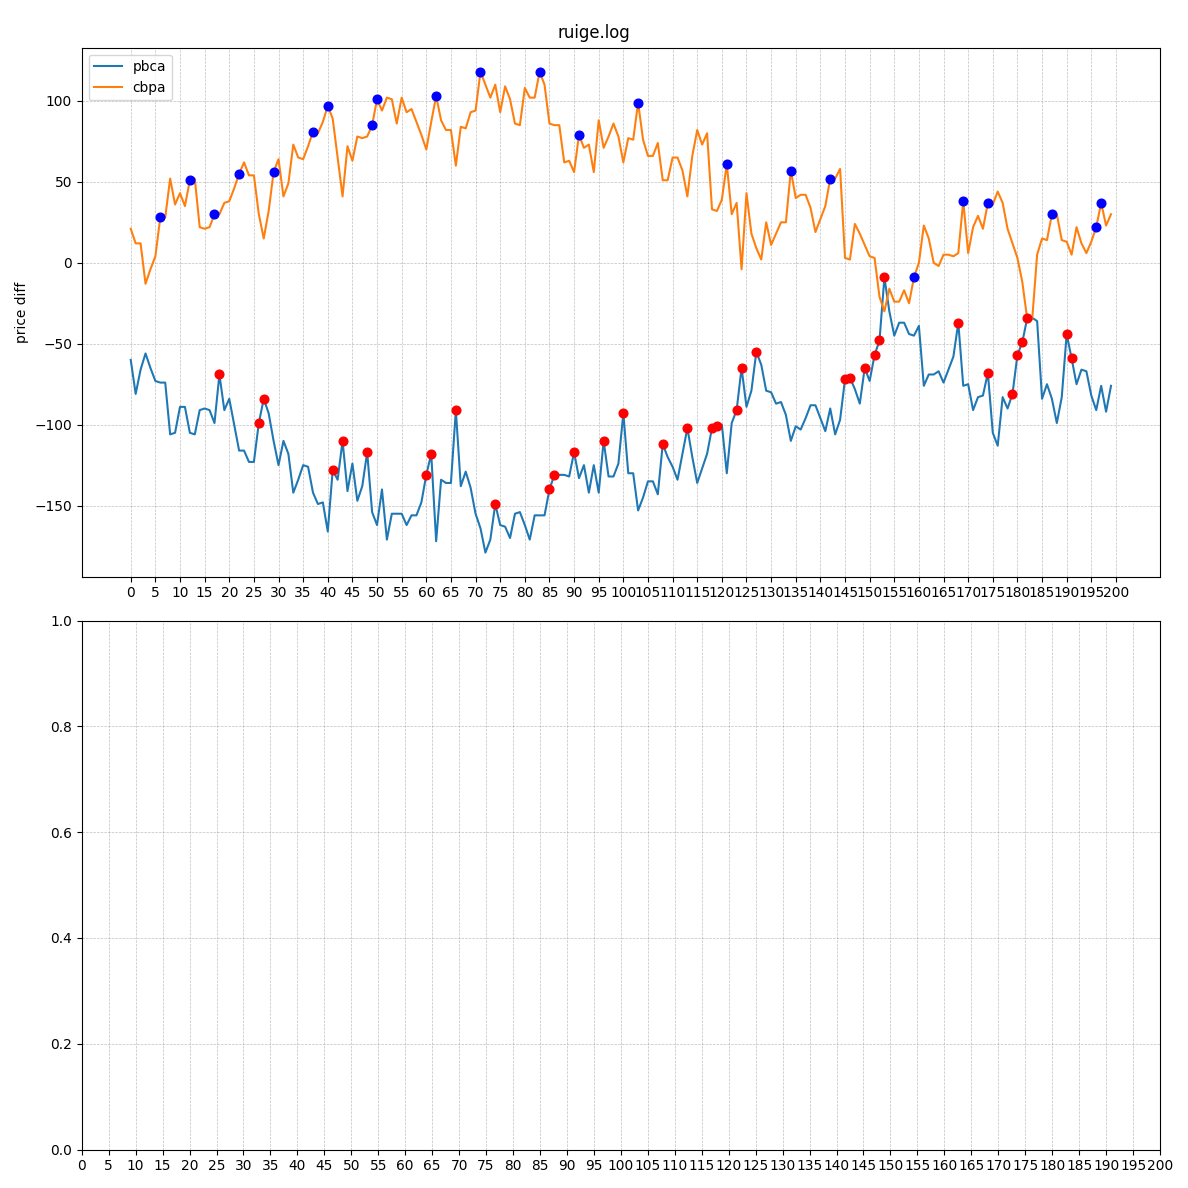

In [68]:
normalized_best_bid_prices = [
    best_bid_list[0] * 8,
    best_bid_list[1] * 15]
normalized_best_ask_prices = [
    best_ask_list[0] * 8,
    best_ask_list[1] * 15]
price_diff = normalized_best_bid_prices[0] - normalized_best_ask_prices[1]
price_diff_rev = normalized_best_bid_prices[1] - normalized_best_ask_prices[0]

window_size = 4
end = 200
n = 1.3

fig, axes = plt.subplots(2,1,figsize=(12, 12),sharex=False)
fig.suptitle(f"{log_file_path.split('/')[-1]}")
fig.set_tight_layout(True)
fig.set_facecolor('white')

avg, std = blg(price_diff[:end], window_size)
avg_rev, std_rev = blg(price_diff_rev[:end], window_size)
x = np.array(range(end))
y = price_diff[:end]
y2 = price_diff_rev[:end]

axes[0].plot(x,y,label="pbca")
axes[0].plot(x,y2, label="cbpa")
rsi = rsi_calc(pd.Series(price_diff),n=window_size)

upper = avg + n * std
upper_rev = avg_rev + 1.5 * std_rev
# lower = avg - n * std
axes[0].set_ylabel("price diff")
if n > 0:
    # axes[0].plot(x, avg[:length], label="moving average")
    # axes[0].fill_between(x, upper[:length], lower[:length], alpha=0.1)
    axes[0].scatter(x[y>avg+10],y[y>avg+10], marker='o',color='red', s=8000/end,zorder=2)
    # axes[0].scatter(x[y>upper],y[y>upper], marker='o',color='red', s=8000/length,zorder=2)
    axes[0].scatter(x[y2>upper_rev],y2[y2>upper_rev], marker='o',color='blue', s=8000/end,zorder=2)
    # axes[0].scatter(x[y<lower],y[y<lower], marker='o',color='red', s=8000/length,zorder=2)
axes[0].legend(loc='upper left')

# rsi_upper = 45
# rsi_lower = 20
# rsi_cond = np.logical_or(rsi[window_size:length] > rsi_upper, rsi[window_size:length] < rsi_lower)
# # Find the indices of the consecutive True elements
# indices = np.where(np.logical_and(rsi_cond[1:], rsi_cond[:-1]))[0] + 1

# agree = np.logical_and(rsi_cond, np.logical_or(y>upper, y<lower))

# axes[0].scatter(x[rsi_cond],price_diff[window_size:length][rsi_cond], color='green', marker="x", s=80, zorder=10)
# axes[0].scatter(x[agree],price_diff[window_size:length][agree], color='yellow', marker="o", s=50, zorder=20)
# axes[1].plot(x,rsi[window_size:length])
# axes[1].axhline(y=rsi_upper)
# axes[1].axhline(y=rsi_lower)

for ax in axes:
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    ax.set_xticks(np.linspace(0,end,41))